In [189]:
import sys
sys.path.append('/home/kai/DAST/network')
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import torch.utils.data.dataloader as Data
import os
import time
from torch.autograd import Variable
from DAST_utils import *
from DAST_Network import *
from torch.utils.data import TensorDataset,DataLoader
import sys
from tqdm import tqdm
import math

In [190]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [191]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [192]:
#Myscore function
def myScore(target, pred):
    print('target', target.shape)
    print('pred', pred.shape)
    Er = 100 * ((target - pred) / target)
    print(Er.shape)
    A = math.exp(-np.log(0.5) * (Er / 5)) if Er <=0 else math.exp(np.log(0.5) * (Er / 20))
    return A

In [193]:
def RMSE(target, pred):
    square_error = (target - pred) ** 2
    mse =  (torch.sum(square_error)) / len(target)
    rmse = mse ** 0.5
    return rmse

In [194]:
def MAE(target, pred):
    absolute_error = np.abs(target - pred)
    return torch.sum(absolute_error) / len(target)

In [195]:
DATA_PATH = '../../../data/10FEMTO/processed_data/'
FOLDER = 'Bearing1_1'

In [196]:
X_np = np.load(f'../../../data/10FEMTO/processed_data/simple_data_2000_40_1_X.npy')
Y_np = np.load(f'../../../data/10FEMTO/processed_data/simple_data_2000_40_1_Y.npy')
X_train, X_test = X_np[:1600], X_np[:2000]
Y_train, Y_test = Y_np[:1600], Y_np[:2000]
Y_train = np.reshape(Y_train, (len(Y_train), -1))
Y_test = np.reshape(Y_test, (len(Y_test), -1))

In [197]:
from sklearn.neural_network import MLPRegressor

In [198]:
# mlp_regressor  = MLPRegressor(hidden_layer_sizes=(5000,), max_iter=2000, random_state=42)
# mlp_regressor.fit(X_train, Y_train)
# predictions = mlp_regressor.predict(X_test)
# import matplotlib.pyplot as plt

# # Example data

# # Plotting the line chart
# plt.plot(predictions, label='Pred', marker='o', markersize=1)
# plt.plot(Y_test, label='Y', marker='o', markersize=1)
# # Adding labels and title
# plt.xlabel('X-axis Label')
# plt.ylabel('Y-axis Label')
# plt.title('Line Chart Example')

# # Adding a legend
# plt.legend()

# # Display the plot
# plt.show()

In [199]:
X_train = Variable(torch.Tensor(X_train).float())
Y_train = Variable(torch.Tensor(Y_train).float())
X_test = Variable(torch.Tensor(X_test).float())
Y_test = Variable(torch.Tensor(Y_test).float())

In [200]:
#Hyperparameters
FEATURE = 1
EMBEDD = 20
batch_size = 256
dim_val = FEATURE
dim_attn = EMBEDD
dim_val_t = FEATURE
dim_attn_t = EMBEDD
dim_val_s = FEATURE
dim_attn_s = EMBEDD
n_heads = 4
n_decoder_layers = 1
n_encoder_layers = 2
lr = 1e-3
epochs = 50
time_step = 40
dec_seq_len = 4
output_sequence_length = 1
input_size = FEATURE

In [201]:
train_dataset = TensorDataset(X_train,Y_train)
train_loader = Data.DataLoader(dataset=train_dataset,batch_size = batch_size,shuffle=False)
test_dataset = TensorDataset(X_test,Y_test)
test_loader = Data.DataLoader(dataset=test_dataset,batch_size = batch_size,shuffle=False)

In [202]:
# Initialize model parameters
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# debug = True
debug = False
model = DAST(dim_val_s,dim_attn_s,dim_val_t,dim_attn_t,dim_val, dim_attn,time_step,input_size,dec_seq_len,output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads, debug)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [203]:
loss_list = []
train_loss_list = []
test_loss_list = []
train_time = []
test_time = []

In [204]:
for epoch in range(epochs):
    #training
    model.train()
    loop = tqdm(train_loader, leave=True)
    for i,(X, Y) in enumerate(loop):
        batch_X = X.to(device)
        batch_Y = Y.to(device)
        out = model(batch_X)
        loss = criterion(out, batch_Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    loss_eopch = np.mean(np.array(loss_list))
    train_loss_list.append(loss_eopch)
    print('epoch = ',epoch,
            'train_loss = ',loss_eopch.item())

    #testing
    model.eval()
    prediction_list = []
    for j ,(batch_x,batch_y) in enumerate(test_loader):
        batch_X = batch_x.to(device)
        batch_Y = batch_y.to(device)
        prediction = model(batch_X)
        # prediction[prediction<0] = 0
        prediction_list.append(prediction)
        
    out_batch_pre = torch.cat(prediction_list).detach().cpu()
    # prediction_tensor = torch.from_numpy(out_batch_pre)
    rmse_loss = RMSE(Y_test, out_batch_pre, )
    mae_loss = MAE(Y_test, out_batch_pre, )
    test_loss = criterion(out_batch_pre, Y_test)
    test_loss_list.append(test_loss)
    print('rmse_loss = ', rmse_loss.item(),
            'mae_loss = ', mae_loss.item(),
            'mse_loss = ', test_loss.item())

100%|██████████| 7/7 [00:00<00:00, 20.20it/s]


epoch =  0 train_loss =  0.060332140918555
rmse_loss =  0.28753721714019775 mae_loss =  0.24776872992515564 mse_loss =  0.08267765492200851


100%|██████████| 7/7 [00:00<00:00, 20.06it/s]


epoch =  1 train_loss =  0.06001188367372379
rmse_loss =  0.28773486614227295 mae_loss =  0.2478846162557602 mse_loss =  0.08279135078191757


100%|██████████| 7/7 [00:00<00:00, 23.27it/s]


epoch =  2 train_loss =  0.05986931744319875
rmse_loss =  0.2878343462944031 mae_loss =  0.2479429692029953 mse_loss =  0.08284860849380493


100%|██████████| 7/7 [00:00<00:00, 23.47it/s]


epoch =  3 train_loss =  0.059788040089188144
rmse_loss =  0.28789782524108887 mae_loss =  0.2479802668094635 mse_loss =  0.08288516104221344


100%|██████████| 7/7 [00:00<00:00, 23.69it/s]


epoch =  4 train_loss =  0.05973554060328752
rmse_loss =  0.2879451513290405 mae_loss =  0.24800804257392883 mse_loss =  0.08291240781545639


100%|██████████| 7/7 [00:00<00:00, 21.86it/s]


epoch =  5 train_loss =  0.059698879156106464
rmse_loss =  0.28798437118530273 mae_loss =  0.2480311244726181 mse_loss =  0.08293500542640686


100%|██████████| 7/7 [00:00<00:00, 24.67it/s]


epoch =  6 train_loss =  0.059671833757216075
rmse_loss =  0.2880192697048187 mae_loss =  0.2480515092611313 mse_loss =  0.08295509964227676


100%|██████████| 7/7 [00:00<00:00, 24.78it/s]


epoch =  7 train_loss =  0.059651039941984764
rmse_loss =  0.2880515158176422 mae_loss =  0.24807050824165344 mse_loss =  0.0829736739397049


100%|██████████| 7/7 [00:00<00:00, 23.06it/s]


epoch =  8 train_loss =  0.05963452232055484
rmse_loss =  0.28808197379112244 mae_loss =  0.24808838963508606 mse_loss =  0.08299122005701065


100%|██████████| 7/7 [00:00<00:00, 23.15it/s]


epoch =  9 train_loss =  0.05962105315245156
rmse_loss =  0.2881110906600952 mae_loss =  0.2481054663658142 mse_loss =  0.08300800621509552


100%|██████████| 7/7 [00:00<00:00, 23.13it/s]


epoch =  10 train_loss =  0.05960982871036251
rmse_loss =  0.28813910484313965 mae_loss =  0.248121976852417 mse_loss =  0.08302414417266846


100%|██████████| 7/7 [00:00<00:00, 23.29it/s]


epoch =  11 train_loss =  0.05960030606920121
rmse_loss =  0.2881661057472229 mae_loss =  0.24813781678676605 mse_loss =  0.08303970098495483


100%|██████████| 7/7 [00:00<00:00, 22.39it/s]


epoch =  12 train_loss =  0.05959210340266249
rmse_loss =  0.28819218277931213 mae_loss =  0.24815310537815094 mse_loss =  0.08305472880601883


100%|██████████| 7/7 [00:00<00:00, 24.15it/s]


epoch =  13 train_loss =  0.05958494694300034
rmse_loss =  0.28821736574172974 mae_loss =  0.24816791713237762 mse_loss =  0.08306924998760223


100%|██████████| 7/7 [00:00<00:00, 23.60it/s]


epoch =  14 train_loss =  0.05957863543825667
rmse_loss =  0.2882417142391205 mae_loss =  0.2481822818517685 mse_loss =  0.08308329433202744


100%|██████████| 7/7 [00:00<00:00, 24.46it/s]


epoch =  15 train_loss =  0.05957301524696439
rmse_loss =  0.28826528787612915 mae_loss =  0.24819611012935638 mse_loss =  0.08309686928987503


100%|██████████| 7/7 [00:00<00:00, 23.72it/s]


epoch =  16 train_loss =  0.05956796945186191
rmse_loss =  0.28828802704811096 mae_loss =  0.2482094168663025 mse_loss =  0.08310998231172562


100%|██████████| 7/7 [00:00<00:00, 24.76it/s]


epoch =  17 train_loss =  0.059563406535224725
rmse_loss =  0.2883099913597107 mae_loss =  0.24822235107421875 mse_loss =  0.08312264829874039


100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


epoch =  18 train_loss =  0.05955925493508129
rmse_loss =  0.2883312404155731 mae_loss =  0.24823489785194397 mse_loss =  0.08313489705324173


100%|██████████| 7/7 [00:00<00:00, 22.90it/s]


epoch =  19 train_loss =  0.059555456335822654
rmse_loss =  0.28835174441337585 mae_loss =  0.2482469230890274 mse_loss =  0.08314672857522964


100%|██████████| 7/7 [00:00<00:00, 23.88it/s]


epoch =  20 train_loss =  0.05955196330149588
rmse_loss =  0.28837156295776367 mae_loss =  0.2482585459947586 mse_loss =  0.08315815776586533


100%|██████████| 7/7 [00:00<00:00, 23.79it/s]


epoch =  21 train_loss =  0.05954873679408368
rmse_loss =  0.2883906960487366 mae_loss =  0.24826979637145996 mse_loss =  0.08316919952630997


100%|██████████| 7/7 [00:00<00:00, 23.67it/s]


epoch =  22 train_loss =  0.059545744383296934
rmse_loss =  0.28840917348861694 mae_loss =  0.24828067421913147 mse_loss =  0.08317984640598297


100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


epoch =  23 train_loss =  0.059542959567070716
rmse_loss =  0.2884270250797272 mae_loss =  0.24829119443893433 mse_loss =  0.08319014310836792


100%|██████████| 7/7 [00:00<00:00, 25.16it/s]


epoch =  24 train_loss =  0.05954035943174469
rmse_loss =  0.2884442210197449 mae_loss =  0.24830129742622375 mse_loss =  0.08320007473230362


100%|██████████| 7/7 [00:00<00:00, 24.81it/s]


epoch =  25 train_loss =  0.05953792436624069
rmse_loss =  0.2884608507156372 mae_loss =  0.24831107258796692 mse_loss =  0.08320966362953186


100%|██████████| 7/7 [00:00<00:00, 23.11it/s]


epoch =  26 train_loss =  0.05953563760015029
rmse_loss =  0.2884768843650818 mae_loss =  0.24832046031951904 mse_loss =  0.08321891725063324


100%|██████████| 7/7 [00:00<00:00, 24.51it/s]


epoch =  27 train_loss =  0.059533485313592364
rmse_loss =  0.2884923815727234 mae_loss =  0.24832962453365326 mse_loss =  0.08322785049676895


100%|██████████| 7/7 [00:00<00:00, 24.34it/s]


epoch =  28 train_loss =  0.05953145471144596
rmse_loss =  0.2885073125362396 mae_loss =  0.24833843111991882 mse_loss =  0.08323647081851959


100%|██████████| 7/7 [00:00<00:00, 23.30it/s]


epoch =  29 train_loss =  0.05952953494575229
rmse_loss =  0.28852173686027527 mae_loss =  0.24834692478179932 mse_loss =  0.08324479311704636


100%|██████████| 7/7 [00:00<00:00, 23.65it/s]


epoch =  30 train_loss =  0.0595277165232252
rmse_loss =  0.2885356843471527 mae_loss =  0.24835512042045593 mse_loss =  0.08325283974409103


100%|██████████| 7/7 [00:00<00:00, 24.08it/s]


epoch =  31 train_loss =  0.05952599085243752
rmse_loss =  0.2885490953922272 mae_loss =  0.24836301803588867 mse_loss =  0.08326058834791183


100%|██████████| 7/7 [00:00<00:00, 24.54it/s]


epoch =  32 train_loss =  0.059524350525464585
rmse_loss =  0.2885620594024658 mae_loss =  0.24837061762809753 mse_loss =  0.08326806873083115


100%|██████████| 7/7 [00:00<00:00, 22.74it/s]


epoch =  33 train_loss =  0.0595227888283445
rmse_loss =  0.28857457637786865 mae_loss =  0.2483779340982437 mse_loss =  0.08327528834342957


100%|██████████| 7/7 [00:00<00:00, 24.53it/s]


epoch =  34 train_loss =  0.0595212998795228
rmse_loss =  0.28858664631843567 mae_loss =  0.24838505685329437 mse_loss =  0.08328224718570709


100%|██████████| 7/7 [00:00<00:00, 24.55it/s]


epoch =  35 train_loss =  0.05951987868978731
rmse_loss =  0.28859826922416687 mae_loss =  0.24839194118976593 mse_loss =  0.08328895270824432


100%|██████████| 7/7 [00:00<00:00, 24.85it/s]


epoch =  36 train_loss =  0.05951852005282525
rmse_loss =  0.28860947489738464 mae_loss =  0.2483985424041748 mse_loss =  0.08329543471336365


100%|██████████| 7/7 [00:00<00:00, 24.40it/s]


epoch =  37 train_loss =  0.059517219884555675
rmse_loss =  0.28862032294273376 mae_loss =  0.24840490520000458 mse_loss =  0.08330168575048447


100%|██████████| 7/7 [00:00<00:00, 24.91it/s]


epoch =  38 train_loss =  0.05951597421530689
rmse_loss =  0.28863075375556946 mae_loss =  0.24841107428073883 mse_loss =  0.08330771327018738


100%|██████████| 7/7 [00:00<00:00, 23.41it/s]


epoch =  39 train_loss =  0.0595147795563597
rmse_loss =  0.2886408269405365 mae_loss =  0.2484169751405716 mse_loss =  0.08331353217363358


100%|██████████| 7/7 [00:00<00:00, 24.64it/s]


epoch =  40 train_loss =  0.05951363266200697
rmse_loss =  0.2886505424976349 mae_loss =  0.24842266738414764 mse_loss =  0.08331913501024246


100%|██████████| 7/7 [00:00<00:00, 24.68it/s]


epoch =  41 train_loss =  0.05951253063604552
rmse_loss =  0.2886599004268646 mae_loss =  0.24842818081378937 mse_loss =  0.08332454413175583


100%|██████████| 7/7 [00:00<00:00, 24.07it/s]


epoch =  42 train_loss =  0.05951147062427046
rmse_loss =  0.2886689603328705 mae_loss =  0.24843347072601318 mse_loss =  0.08332976698875427


100%|██████████| 7/7 [00:00<00:00, 23.92it/s]


epoch =  43 train_loss =  0.05951045019372197
rmse_loss =  0.2886776626110077 mae_loss =  0.24843862652778625 mse_loss =  0.0833347961306572


100%|██████████| 7/7 [00:00<00:00, 23.41it/s]


epoch =  44 train_loss =  0.059509467207161444
rmse_loss =  0.288686066865921 mae_loss =  0.2484436184167862 mse_loss =  0.0833396464586258


100%|██████████| 7/7 [00:00<00:00, 23.70it/s]


epoch =  45 train_loss =  0.0595085194402357
rmse_loss =  0.2886941730976105 mae_loss =  0.24844840168952942 mse_loss =  0.08334432542324066


100%|██████████| 7/7 [00:00<00:00, 24.65it/s]


epoch =  46 train_loss =  0.059507604902836644
rmse_loss =  0.28870198130607605 mae_loss =  0.24845299124717712 mse_loss =  0.0833488404750824


100%|██████████| 7/7 [00:00<00:00, 23.25it/s]


epoch =  47 train_loss =  0.05950672199382791
rmse_loss =  0.28870952129364014 mae_loss =  0.2484574317932129 mse_loss =  0.083353191614151


100%|██████████| 7/7 [00:00<00:00, 24.48it/s]


epoch =  48 train_loss =  0.05950586899806835
rmse_loss =  0.28871679306030273 mae_loss =  0.2484617382287979 mse_loss =  0.08335739374160767


100%|██████████| 7/7 [00:00<00:00, 24.92it/s]


epoch =  49 train_loss =  0.0595050441616747
rmse_loss =  0.28872382640838623 mae_loss =  0.24846585094928741 mse_loss =  0.0833614394068718


In [205]:
z = np.reshape(out_batch_pre, (-1))
z = z.tolist()

In [206]:
y = Y_test.detach().cpu().numpy()
y = np.reshape(y, -1)
y = y.tolist()

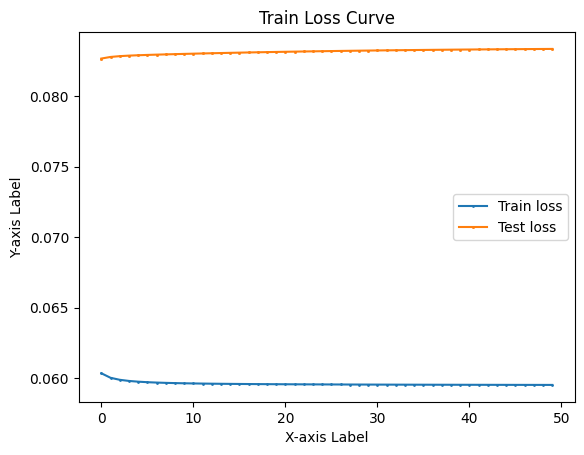

In [207]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(train_loss_list, label='Train loss', marker='o', markersize=1)
plt.plot(test_loss_list, label='Test loss', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Train Loss Curve')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

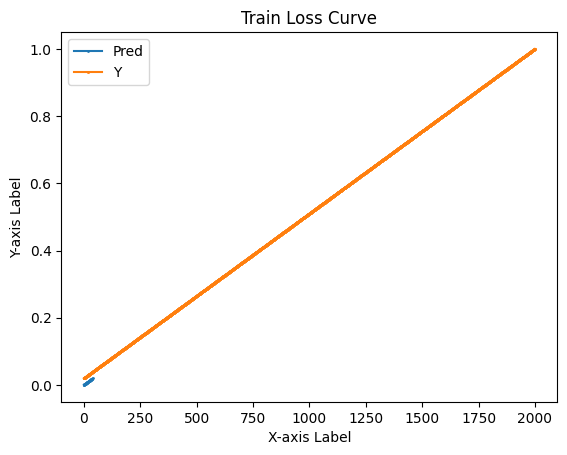

In [208]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(X_np[0], label='Pred', marker='o', markersize=1)
plt.plot(Y_np, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Train Loss Curve')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

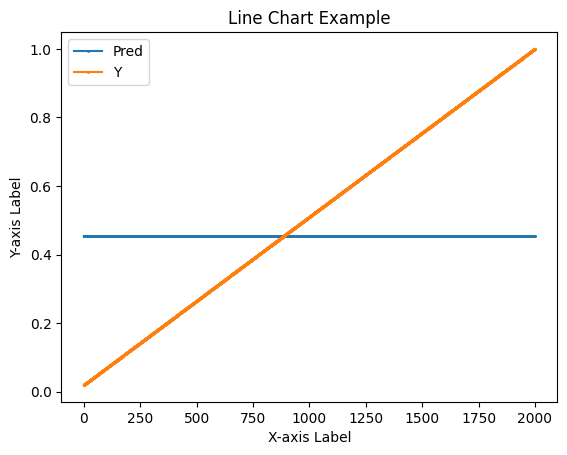

In [209]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(z, label='Pred', marker='o', markersize=1)
plt.plot(y, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Line Chart Example')

# Adding a legend
plt.legend()

# Display the plot
plt.show()